In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
import numpy as np

In [2]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS=10

In [3]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "Tomato",
    shuffle=True,
    image_size = (IMAGE_SIZE, IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

Found 5697 files belonging to 3 classes.


In [4]:
class_names = dataset.class_names
class_names

['Tomato___Early_blight', 'Tomato___Late_blight', 'Tomato___healthy']

In [5]:


for image_batch, label_batch in dataset.take(1):
    print(image_batch.shape)
    print(label_batch.numpy())

(32, 256, 256, 3)
[0 2 0 0 0 1 1 1 0 2 2 0 1 2 0 0 2 2 0 1 0 1 2 2 1 1 2 2 2 1 2 2]


In [6]:
for image_batch, label_batch in dataset.take(1):
    print(image_batch[0].shape)

(256, 256, 3)


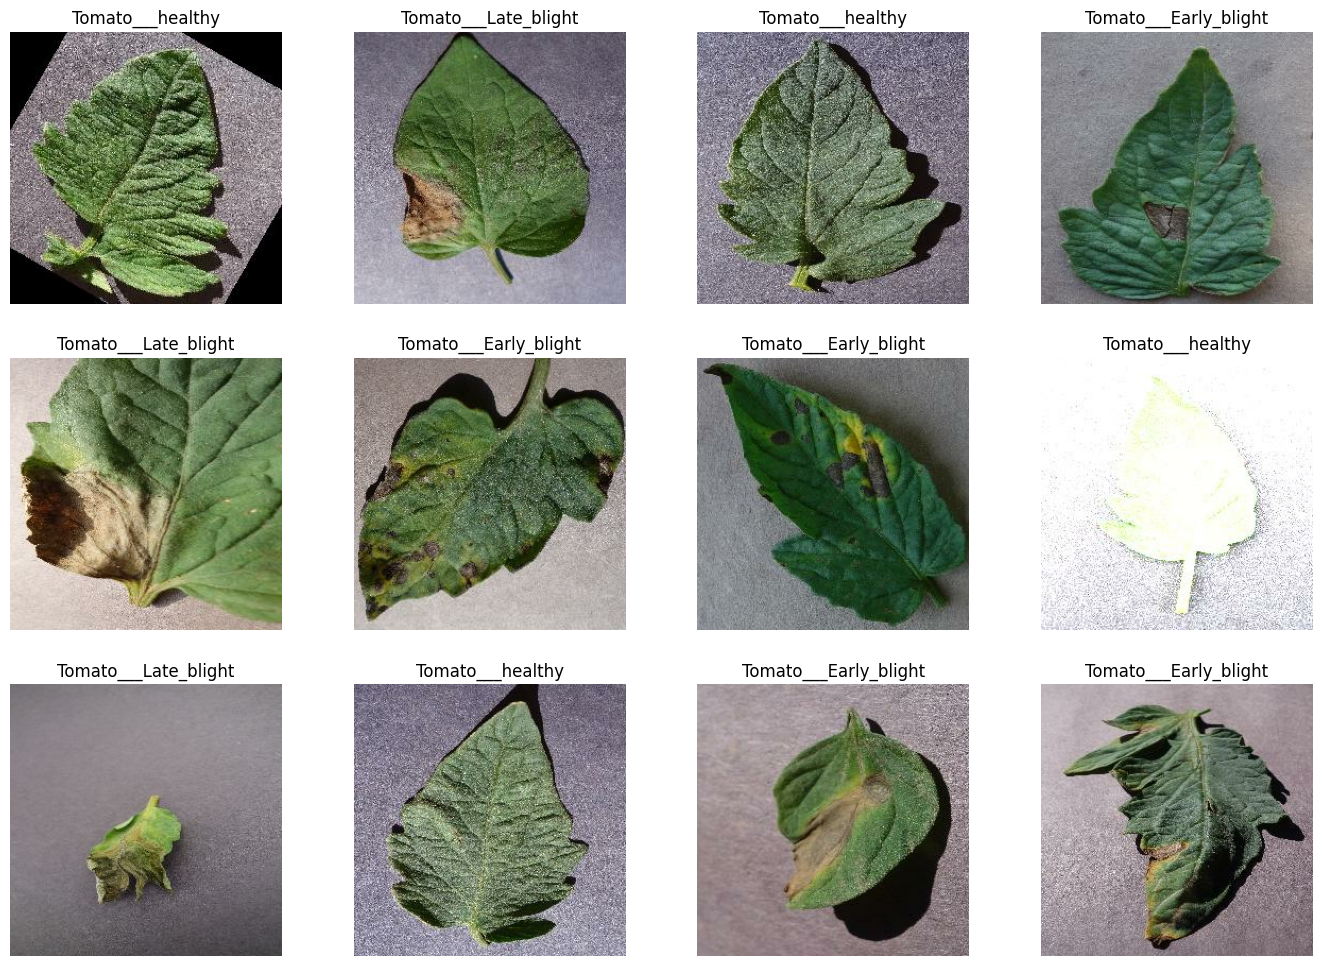

In [7]:
plt.figure(figsize=(17,12))
for image_batch, label_batch in dataset.take(1):
    for i in range(12):
        plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")

In [8]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True,shuffle_size=10000):
    
    ds_size=len(ds)
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)
    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [9]:
train_ds,val_ds,test_ds = get_dataset_partitions_tf(dataset)

In [10]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [11]:
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE,IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [12]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2),
])

In [13]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32,(3,3), activation='relu', input_shape = input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])
model.build(input_shape = input_shape)

In [14]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (32, 127, 127, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (32, 62, 62, 64)         0         
 2D)                                                  

In [15]:
model.compile(
    optimizer ='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [16]:
history = model.fit(
    train_ds, 
    epochs=EPOCHS, 
    batch_size=BATCH_SIZE, 
    verbose=1, 
    validation_data=val_ds,
)

Epoch 1/10
143/143 [==============================] - 252s 2s/step - loss: 0.8190 - accuracy: 0.5582 - val_loss: 0.7085 - val_accuracy: 0.6783
Epoch 2/10
143/143 [==============================] - 260s 2s/step - loss: 0.6003 - accuracy: 0.7329 - val_loss: 0.6607 - val_accuracy: 0.7555
Epoch 3/10
143/143 [==============================] - 272s 2s/step - loss: 0.4293 - accuracy: 0.8086 - val_loss: 0.5636 - val_accuracy: 0.8107
Epoch 4/10
143/143 [==============================] - 263s 2s/step - loss: 0.3776 - accuracy: 0.8385 - val_loss: 0.3210 - val_accuracy: 0.8676
Epoch 5/10
143/143 [==============================] - 256s 2s/step - loss: 0.3086 - accuracy: 0.8704 - val_loss: 0.3222 - val_accuracy: 0.8640
Epoch 6/10
143/143 [==============================] - 253s 2s/step - loss: 0.3558 - accuracy: 0.8508 - val_loss: 0.4150 - val_accuracy: 0.8401
Epoch 7/10
143/143 [==============================] - 247s 2s/step - loss: 0.2858 - accuracy: 0.8851 - val_loss: 0.2844 - val_accuracy: 0.8805

In [17]:
scores = model.evaluate(test_ds)

19/19 [==============================] - 13s 360ms/step - loss: 0.2260 - accuracy: 0.9194


In [18]:
scores

[0.22601652145385742, 0.9194079041481018]

In [19]:
history.params

{'verbose': 1, 'epochs': 10, 'steps': 143}

First image to predict
Actual label:  Tomato___Late_blight
1/1 [==============================] - 2s 2s/step
Predicted label:  Tomato___Late_blight


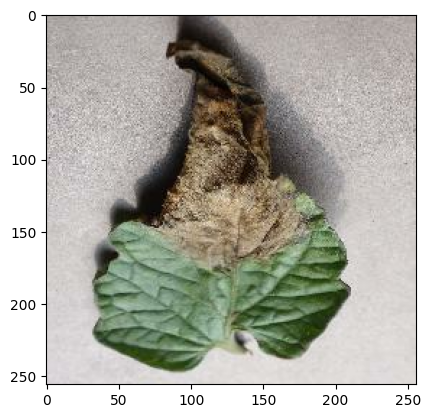

In [20]:
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("First image to predict")
    plt.imshow(first_image)
    print("Actual label: ",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("Predicted label: ",class_names[np.argmax(batch_prediction[0])])

In [21]:
def predict(model,img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)
    
    predictions = model.predict(img_array)
    
    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])),2)
    return predicted_class, confidence

1/1 [==============================] - 0s 63ms/step


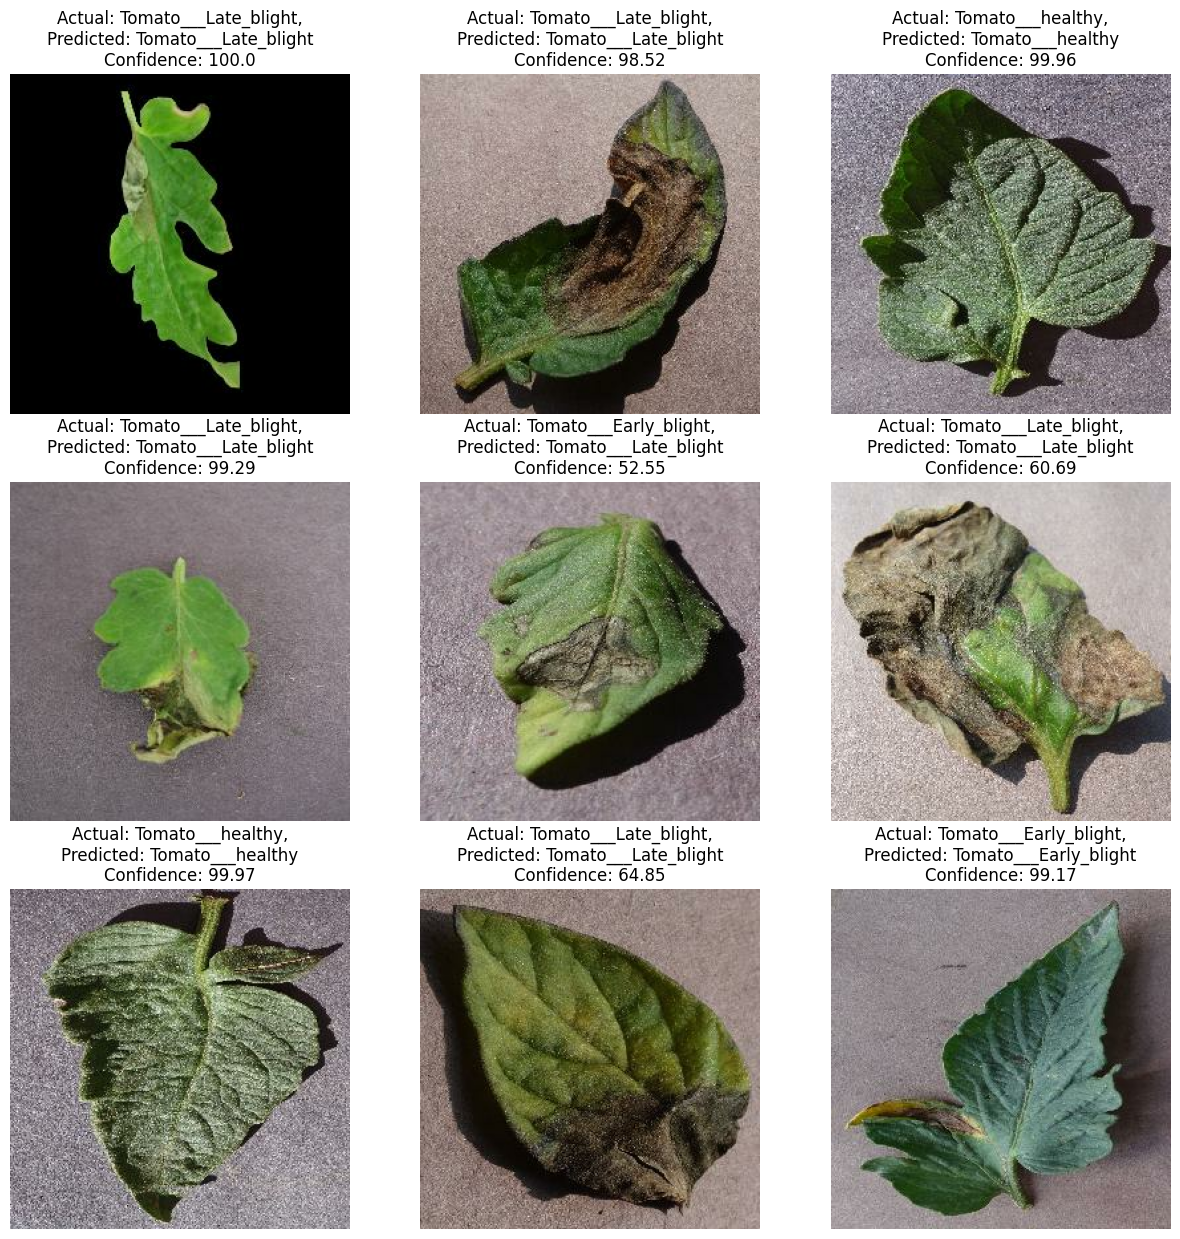

In [22]:
plt.figure(figsize=(15,15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype('uint8'))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]
        
        plt.title(f"Actual: {actual_class},\nPredicted: {predicted_class}\nConfidence: {confidence}")
        
        plt.axis('off')

In [23]:
model_version = 1
model.save(f"../models/{model_version}")

INFO:tensorflow:Assets written to: ../models/1\assets


INFO:tensorflow:Assets written to: ../models/1\assets


In [24]:
import pickle

In [25]:
with open('C:/Users/User/Desktop/Plant Disease Classification/training/blight.sav', 'wb') as f:
    pickle.dump(object, f)

In [26]:
%%writefile blight.py

import streamlit as st
import tensorflow as tf

st.set_option('deprecation.showfileUploaderEncoding', False)
@st.cache(allow_output_mutation=True)
def load_model():
    model = tf.keras.models.load_model('blight.sav')
    return model

model = load_model()
st.write(
    """
    #Plant Disease Classification
    """
)

file = st.file_uploader("Upload a file", type=['jpg','png'])

import cv2
from PIL import Image, ImageOps

import numpy as np

def import_and_predict(image_data,model):
    size = (180,180)
    image = ImageOps.fit(image_data,size,Image.ANTIALIAS)
    img = np.asarray()
    img_reshape = img[np.newaxis,...]
    prediction = model.predict(img_reshape)

    return prediction

if file is None:
    st.text("Please upload an image file")

else:
    image = Image.open(file)
    st.image(image, use_column_width=True)
    prediction = import_and_predict(image,model)
    class_names = ["Early_Blight","Late_Blight","Healthy"]
    string = "This disease is most likely "+class_names[np.argmax(prediction)]
    st.success(string)




Overwriting blight.py


In [27]:
!ngrok authtoken 2LYC0T4lGRO4dw9LPqXrIPnVOwL_4G58gpeM6bqbTseMnLSE3

Authtoken saved to configuration file: C:\Users\User/.ngrok2/ngrok.yml


In [34]:
import os

get_ipython().system = os.system
!nohup streamlit run blight.py &

0

In [38]:
from pyngrok import ngrok
url = ngrok.connect(port=8501)
url

PyngrokNgrokHTTPError: ngrok client exception, API returned 502: {"error_code":103,"status_code":502,"msg":"failed to start tunnel","details":{"err":"EOF"}}
